# TasteNet-MNL 

El presente notebook busca replicar experimentos de los autores del paper de TasteNet-MNL con el uso de la librería Choice Learn de python.

Ventajas de utilizar la implementación de Choice Learn por sobre las implementaciones de los autores de los modelos por los siguientes motivos:

- **Escalabilidad**:

Choice Learn está diseñado con metodologías de diseño modular, lo que lo hace escalable y permite realizar cambios en él eficientemente, sin tener la necesidad de cambiar grandes porciones del código.

- **Enfoque a los grandes volúmenes de datos**:

Choice Learn tiene funciones para el manejo eficiente en memoria de grandes volúmenes de datos, usando en el backend numpy y pandas.

- **Mantenimiento**:

Choice Learn es una librería open source que actualmente está recibiendo mantenimiento por parte de sus creadores, de modo que errores, extensiones o issues pueden ser atendidas.

- **Documentación**:

Choice Learn presenta una documentación acabada de sus funciones, métodos y modelos implementados.

- **Completitud**:

Choice Learn tiene todas las funcionalidades necesarias e implementadas en el código del paper de TasteNet y además incluye otros métodos que lo extienden.

### Índice
- [Data Loading](#data-loading)
- [Model Parametrization](#model-parametrization)
- [Model Estimation](#model-estimation)
- [Estimated Tastes Analysis](#estimated-tastes-analysis)
- [References](#references)

In [1]:
import numpy as np
import pandas as pd

from choice_learn.datasets import load_swissmetro
from choice_learn.models.tastenet import TasteNet

In [18]:
# The preprocessing="tastenet" let us format the data just like in the paper
customers_id, dataset = load_swissmetro(preprocessing="tastenet", as_frame=False)

In [13]:
print("Items Features:", dataset.items_features_by_choice_names)
print("Shared Features:", dataset.shared_features_by_choice_names)

Items Features: (['CO', 'TT', 'HE', 'SEATS', 'ASC_TRAIN', 'ASC_SM', 'ASC_CAR'],)
Shared Features: (['MALE', 'FEMALE', 'FIRST', 'NOT_FIRST', 'GA', 'NOT_GA', 'AGE_1', 'AGE_2', 'AGE_3', 'AGE_4', 'AGE_5', 'INCOME_1.0', 'INCOME_2.0', 'INCOME_3.0', 'INCOME_4.0', 'WHO_1.0', 'WHO_2.0', 'WHO_3.0', 'PURPOSE_1', 'PURPOSE_2', 'PURPOSE_3', 'PURPOSE_4', 'LUGGAGE_0', 'LUGGAGE_1', 'LUGGAGE_3'],)


### Parametrización del modelo

Los elementos del conjunto de datos están ordenados: "TREN", "SM" y "CAR". Ahora podemos configurar los hiperparámetros del modelo TasteNet.
- **taste_net_layers:** lista del número de neuronas para cada capa en TasteNet
- **taste_net_activation:** función de activación que se utilizará dentro de TasteNet
- **items_features_by_choice_parametrization:** parametrización de los coeficientes estimados para los atributos de las alternativas.

TasteNet utiliza las características del cliente (shared_features_by_choice) para estimar los coeficientes que se multiplicarán con los atributos de las alternativas (items_features_by_choice) para estimar la utilidad:

$$ U(alternativa) = \sum_{i \in características alternativas} f(NN_i(\text{características del cliente})) \cdot i$$

Con $f$ una función de normalización que se puede utilizar para establecer algunas restricciones como la positividad.

**items_features_by_choice_parametrization** describe la parametrización de cada característica alternativa y, por lo tanto, debe tener la misma forma, (3, 7) en nuestro caso. Los índices también deben coincidir.
- si el parámetro es flotante, el valor se utiliza directamente para multiplicar la característica correspondiente.
- si el parámetro es una cadena, indica qué función $f$ usar, lo que significa que usaremos la red neuronal de sabor para estimar un parámetro antes de usar $f$.

In [20]:
taste_net_layers = []
taste_net_activation = "relu"
items_features_by_choice_parametrization = [[-1., "-exp", "-exp", 0., "linear", 0., 0.],
                            [-1., "-exp", "-exp", "linear", 0., "linear", 0.],
                            [-1., "-exp", 0., 0., 0., 0., 0.]]

En el ejemplo del paper las utilidades definidas por *items_features_by_choice_parametrization* son las siguientes:

Con $\mathcal{C}$ las características del cliente y $NN_k$ el output de TasteNet:
$$
U(train) = -1 \cdot train_{CO} - e^{-NN_1(\mathcal{C})} \cdot train_{TT} - e^{-NN_2(\mathcal{C})} \cdot train_{HE} + NN_3(\mathcal{C}) \cdot ASC_{train}
$$

$$
U(sm) = -1 \cdot sm_{CO} - e^{-NN_4(\mathcal{C})} \cdot sm_{TT} - e^{-NN_5(\mathcal{C})} \cdot sm_{HE} + NN_6(\mathcal{C}) \cdot sm_{SEATS} + NN_7(\mathcal{C}) \cdot ASC_{sm}
$$

$$
U(car) = -1 \cdot car_{CO} - e^{-NN_8(\mathcal{C})} \cdot car_{TT} 
$$

Para evaluar el modelo, trabajamos con Cross-Validation. Debemos prestar atención a que la división tenga en cuenta el hecho de que la misma persona ha respondido varias veces y aparece varias veces en el conjunto de datos. Trabajamos con una estrategia de *GroupOut*, lo que significa que una persona tiene todas sus respuestas en el mismo fold de prueba.

### Model estimation

In [21]:
from sklearn.model_selection import GroupKFold

folds_history = []
folds_test_nll = []
gkf = GroupKFold(n_splits=5)
# specift customer_id to regroup each customer answer
for train, test in gkf.split(list(range(len(dataset))), list(range(len(dataset))), customers_id): 
    tastenet = TasteNet(taste_net_layers=taste_net_layers,
                    taste_net_activation=taste_net_activation,
                    items_features_by_choice_parametrization=items_features_by_choice_parametrization,
                    optimizer="Adam",
                    epochs=40,
                    lr=0.001,
                    batch_size=32)
    train_dataset, test_dataset = dataset[train], dataset[test]
    hist = tastenet.fit(train_dataset, val_dataset=test_dataset)
    folds_history.append(hist)
    folds_test_nll.append(tastenet.evaluate(test_dataset))

Epoch 39 Train Loss 0.6949: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


Necesitamos poner atención al overfitting, se muestra un gráfico para entender cada fold de train/test en cada época de entrenamiento:

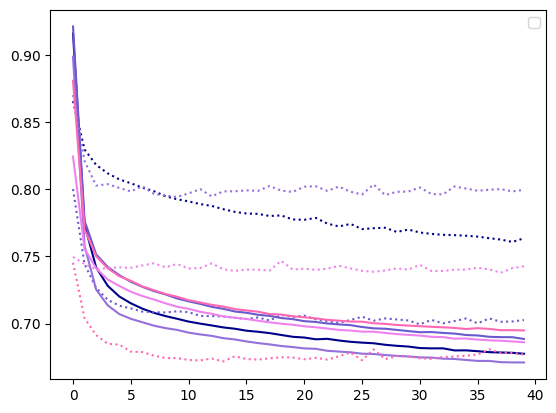

In [22]:
import matplotlib.pyplot as plt
for hist, color in zip(folds_history,
                       ["darkblue", "slateblue", "mediumpurple", "violet", "hotpink"]):
    plt.plot(hist["train_loss"], c=color)
    plt.plot(hist["test_loss"], c=color, linestyle="dotted")
plt.legend()
plt.show()

In [23]:
print("Average NegativeLogLikelihood on testing set:", np.mean(folds_test_nll))

Average NegativeLogLikelihood on testing set: 0.73730266


### Estimated Tastes Analysis
Con el objetivo de analizar el modelo, veamos los coeficientes promedio entregados por TasteNet para cada atributo:

In [24]:
for (item_index, feature_index), nn_output_index in tastenet.items_features_to_weight_index.items():
    print("Alternative:", ["train", "sm", "car"][item_index])
    print("Feature:", dataset.items_features_by_choice_names[0][feature_index])
    print("Average value over dataset:")
    act = tastenet.get_activation_function(items_features_by_choice_parametrization[item_index][feature_index])
    print(np.mean(act(tastenet.predict_tastes(dataset.shared_features_by_choice[0])[:, nn_output_index])))
    print("----------------------------\n")

Alternative: train
Feature: TT
Average value over dataset:
-1.8151973
----------------------------

Alternative: train
Feature: HE
Average value over dataset:
-1.0418051
----------------------------

Alternative: train
Feature: ASC_TRAIN
Average value over dataset:
0.4006502
----------------------------

Alternative: sm
Feature: TT
Average value over dataset:
-1.4793162
----------------------------

Alternative: sm
Feature: HE
Average value over dataset:
-1.3888301
----------------------------

Alternative: sm
Feature: SEATS
Average value over dataset:
0.46000838
----------------------------

Alternative: sm
Feature: ASC_SM
Average value over dataset:
0.6007032
----------------------------

Alternative: car
Feature: TT
Average value over dataset:
-1.2411734
----------------------------

